## 문서 유사도 측정 방법 - 코사인 유사도

- A와 B는 벡터
- 내적(A, B)은 A와 B의 내적입니다.
- ||아|| 그리고 ||비|| 는 각각 벡터 A와 B의 유클리드 규범(또는 길이)입니다.

In [25]:
import sklearn
import nltk
import string
import glob, os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from nltk.stem import WordNetLemmatizer


In [1]:
def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = np.sqrt(sum(np.square(v1)) * np.sqrt(sum(np.square(v2))))
    similarity = dot_product / l2_norm
    
    return similarity

In [4]:
doc_list = ["If you take the blue pill, the story ends",
           "If you take the red pill, you stay in Wonderland",
           "If you take the red pill, I show you how deep the rabbit hole goes"]

tfidf = TfidfVectorizer()
feature_vect = tfidf.fit_transform(doc_list)
print(feature_vect.shape)

(3, 18)


In [5]:
feature_vect_dense = feature_vect.todense()

vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect2 = np.array(feature_vect_dense[1]).reshape(-1,)

similarity = cos_similarity(vect1, vect2)

print(f"문장 1, 문장 2 Cosine 유사도 : {similarity :.4f}")

문장 1, 문장 2 Cosine 유사도 : 0.4021


In [7]:
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)

similarity = cos_similarity(vect1, vect3)

print(f"문장 1, 문장 3 Cosine 유사도 : {similarity :.4f}")

similarity = cos_similarity(vect2, vect3)

print(f"문장 2, 문장 3 Cosine 유사도 : {similarity :.4f}")

문장 1, 문장 3 Cosine 유사도 : 0.4043
문장 2, 문장 3 Cosine 유사도 : 0.4565


In [10]:
similarity_pair = cosine_similarity(feature_vect[0], feature_vect)

print(similarity_pair)

[[1.         0.40207758 0.40425045]]


In [12]:
similarity_pair = cosine_similarity(feature_vect[0], feature_vect[1:])

print(similarity_pair)

[[0.40207758 0.40425045]]


In [13]:
similarity_pair = cosine_similarity(feature_vect, feature_vect)
print(similarity_pair)
print("shape : ", similarity_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
shape :  (3, 3)


## Opinion Review 데이터 셋을 이용한 문서 유사도 측정

In [21]:
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNomalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [19]:
filename_list = []
opinion_text = []

path = r"C:\hmkd1\m5_ml\OpinosisDataset1.0\topics"

all_files = glob.glob(os.path.join(path, "*.data"))

for file_ in all_files:
    df = pd.read_table(file_, index_col = None, header = 0, encoding = "latin1")
    
    filename_ = file_.split("\\")[-1]
    filename = filename_.split(".")[0]
    
    filename_list.append(filename)
    opinion_text.append(df.to_string())
    
documentDF = pd.DataFrame({"filename" : filename_list, "opinion_text" : opinion_text})
documentDF.head()

,filename,opinion_text
0,accuracy_garmin_nuvi_255W_gps,...
1,bathroom_bestwestern_hotel_sfo,...
2,battery-life_amazon_kindle,...
3,battery-life_ipod_nano_8gb,...
4,battery-life_netbook_1005ha,...


In [22]:
tfidf_vect = TfidfVectorizer(tokenizer = LemNomalize, stop_words = "english",
                            ngram_range = (1,2), min_df = 0.05, max_df = 0.85)

feature_vect = tfidf_vect.fit_transform(documentDF["opinion_text"])

km_cluster = KMeans(n_clusters = 5, max_iter = 10000, random_state = 0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

documentDF["cluster_label"] = cluster_label
documentDF.head()

C:\Users\h\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:394: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,...,2
1,bathroom_bestwestern_hotel_sfo,...,0
2,battery-life_amazon_kindle,...,1
3,battery-life_ipod_nano_8gb,...,1
4,battery-life_netbook_1005ha,...,1


In [24]:
hotel_indexes = documentDF[documentDF["cluster_label"] == 2].index
print("호텔로 클러스터링 된 문서들의 DataFrame Index : ", hotel_indexes)

comparison_docname = documentDF.iloc[hotel_indexes[0]]["filename"]
print("##### 비교 기준 문서명 ", comparison_docname, " 와 타 문서 유사도 #####")


'''documentDF에서 추출한 Index 객체를 feature_vect로 입력하여 호텔 클러스터링 된 feature_vect 추출
이를 이용하여 호텔로 클러스터링 된 문서 중 첫 번 째 문서와 다른 문서간의 코사인 유사도 측정.'''

similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]], feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 클러스터링 된 문서들의 DataFrame Index :  Int64Index([0, 5, 8, 9, 10, 11, 12, 23, 33, 34, 35, 36, 43, 48, 49, 50], dtype='int64')
##### 비교 기준 문서명  accuracy_garmin_nuvi_255W_gps  와 타 문서 유사도 #####
[[1.         0.01659167 0.34657949 0.19665144 0.03271487 0.03613626
  0.01828703 0.0511192  0.10104874 0.15598296 0.03667107 0.03388559
  0.20146574 0.18343275 0.01715513 0.12148216]]


Text(0.5, 1.0, 'accuracy_garmin_nuvi_255W_gps')

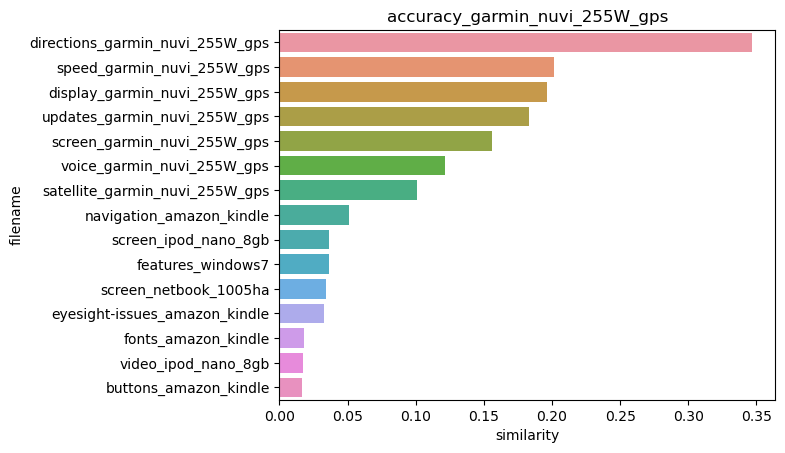

In [27]:
sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:, 1:]

hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df["filename"] = documentDF.iloc[hotel_sorted_indexes]["filename"]
hotel_1_sim_df["similarity"] = hotel_1_sim_value

sns.barplot(x = "similarity", y = "filename", data = hotel_1_sim_df)
plt.title(comparison_docname)